# **MoE Experiments**

First we just want to import the `Transformer` class as well as all of our custom MoE modules.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import einops
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborne as sns
import time

from transformer import Transformer
from moes import RegularMoE, RandomMoE, OrthogonalMoE, HashMoE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cpu" and torch.backends.mps.is_available():
    device = torch.device("mps")
    torch.mps.manual_seed(67960)
if device.type == "cuda" or device.type == "cpu":
    torch.manual_seed(67960)

B = 64
V = 256

print(f"Using device: {device}")

Using device: mps


Next, we want to import our data and get it ready to use.

In [2]:
from datasets import load_dataset
from torch.utils.data import DataLoader
from tokenizers import Tokenizer, models, pre_tokenizers, trainers
import torch

# load dataset
print("Loading AG News dataset...")
dataset = load_dataset("ag_news")
train_data = dataset['train']
test_data = dataset['test']

# Train a simple BPE tokenizer on AG News (vocab V)
print("Training BPE tokenizer with vocab_size=V...")
tokenizer_obj = Tokenizer(models.BPE())
tokenizer_obj.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)

# Train on first 10k samples (fast: ~10 seconds)
trainer = trainers.BpeTrainer(vocab_size=V, special_tokens=["<PAD>", "<UNK>"])
tokenizer_obj.train_from_iterator(
    (train_data[i]['text'] for i in range(min(10000, len(train_data)))),
    trainer=trainer
)

# Simple wrapper to match expected API
class SimpleTokenizer:
    def __init__(self, tok):
        self.tok = tok
        self.pad_token_id = 0
        
    def __call__(self, text, truncation=True, max_length=128, padding='max_length', return_tensors='pt'):
        encoding = self.tok.encode(text)
        tokens = encoding.ids[:max_length]
        tokens = tokens + [self.pad_token_id] * (max_length - len(tokens))
        return {'input_ids': torch.tensor([tokens])}
    
    def decode(self, ids):
        return self.tok.decode(ids.tolist() if isinstance(ids, torch.Tensor) else ids)

tokenizer = SimpleTokenizer(tokenizer_obj)
vocab_size = tokenizer_obj.get_vocab_size()

print(f"Vocab size: {vocab_size}")
print(f"Train samples: {len(train_data)}, Test samples: {len(test_data)}")

# dataset class
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, max_len=128):
        self.data = hf_dataset
        self.max_len = max_len
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text = self.data[idx]['text']
        encoding = tokenizer(text, max_length=self.max_len+1)
        tokens = encoding['input_ids'].squeeze(0)
        
        x = tokens[:-1]
        y = tokens[1:]
        mask = (x != tokenizer.pad_token_id)
        return x, y, mask

# create dataloaders
train_dataset = TextDataset(train_data, max_len=128)
test_dataset = TextDataset(test_data, max_len=128)
train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=B, shuffle=False, num_workers=0)

print("\n*Data done loading*")


/Users/bobby/67960-final-project/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading AG News dataset...
Training BPE tokenizer with vocab_size=V...



Vocab size: 256
Train samples: 120000, Test samples: 7600

*Data done loading*


Before we do anything, we want to set up some constants and create our `Transformers`

In [3]:
D = 64
H = 128
N = 32
K = 4
V = vocab_size
n_heads = 16
n_layers = 6
max_seq_len = 128

print(f"D: {D}\n H: {H}\n N: {N}\n K: {K}\n V: {V}\n n_heads: {n_heads}\n n_layers: {n_layers}\n max_seq_len: {max_seq_len}")

# create models
moe_fns = [
    lambda: RegularMoE(D, H, N, K),
    lambda: RandomMoE(D, H, N, K),
    lambda: OrthogonalMoE(D, H, N, K),
    lambda: HashMoE(D, H, N, K)
]
models = [Transformer(V, D, n_heads, n_layers, moe_fn, max_seq_len).to(device) for moe_fn in moe_fns]

# print number of parameters in each model
for i, model in enumerate(models):
    print(f"Model {i+1} ({moe_fns[i]().__class__.__name__}) has {sum(p.numel() for p in model.parameters())} parameters and {sum(p.numel() for p in model.parameters() if p.requires_grad)} trainable parameters")

D: 64
 H: 128
 N: 32
 K: 4
 V: 256
 n_heads: 16
 n_layers: 6
 max_seq_len: 128
Model 1 (RegularMoE) has 4911936 parameters and 4911936 trainable parameters
Model 2 (RandomMoE) has 4911936 parameters and 4899456 trainable parameters
Model 3 (OrthogonalMoE) has 4899456 parameters and 4899456 trainable parameters
Model 4 (HashMoE) has 4899456 parameters and 4899456 trainable parameters


Now we can finally train all of our models separately and then compare their results to each other


Training Model 1/4: RegularMoE
1875 batches to process...
Processed 100 batches...
Processed 200 batches...
Processed 300 batches...
Processed 400 batches...
Processed 500 batches...
Processed 600 batches...
Processed 700 batches...
Processed 800 batches...
Processed 900 batches...
Processed 1000 batches...
Processed 1100 batches...
Processed 1200 batches...
Processed 1300 batches...
Processed 1400 batches...
Processed 1500 batches...
Processed 1600 batches...
Processed 1700 batches...
Processed 1800 batches...
Epoch 1/3 | Train Loss: 4.1001 | Test Loss: 2.8877 | Time: 855.43s
1875 batches to process...
Processed 100 batches...
Processed 200 batches...
Processed 300 batches...
Processed 400 batches...
Processed 500 batches...
Processed 600 batches...
Processed 700 batches...
Processed 800 batches...
Processed 900 batches...
Processed 1000 batches...
Processed 1100 batches...
Processed 1200 batches...
Processed 1300 batches...
Processed 1400 batches...
Processed 1500 batches...
Process

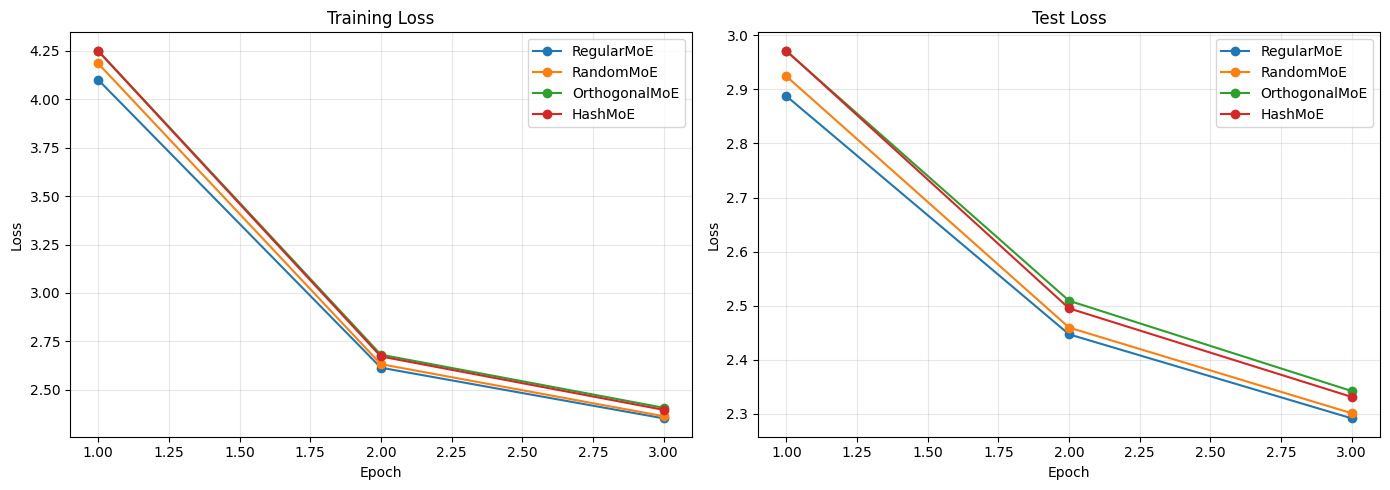

In [4]:
def train_epoch(model, loader, optimizer, device):
    """Train for one epoch, return average loss"""
    model.train()
    total_loss = 0
    num_batches = 0

    print(f"{len(loader)} batches to process...")
    
    for x, y, mask in loader:
        x, y, mask = x.to(device), y.to(device), mask.to(device)
        
        # tm1 = time.time()
        logits = model(x, mask)  # [B, S, V]
        # tm2 = time.time()
        # print(f"Time taken for forward pass: {tm2 - tm1:.4f}s")
        
        loss = F.cross_entropy(logits.view(-1, V), y.view(-1), ignore_index=tokenizer.pad_token_id)
        
        # tm1 = time.time()
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        # tm2 = time.time()
        # print(f"Time taken for backward pass: {tm2 - tm1:.4f}s")
        
        total_loss += loss.item()
        num_batches += 1
        if num_batches % 100 == 0:
            print(f"Processed {num_batches} batches...")
    return total_loss / num_batches

@torch.no_grad()
def evaluate(model, loader, device):
    """Evaluate on dataset, return average loss"""
    model.eval()
    total_loss = 0
    num_batches = 0
    
    for x, y, mask in loader:
        x, y, mask = x.to(device), y.to(device), mask.to(device)
        logits = model(x, mask)
        loss = F.cross_entropy(logits.view(-1, V), y.view(-1), ignore_index=tokenizer.pad_token_id)
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches

# Training config
num_epochs = 3
lr = 3e-4
model_names = [models[i].moe_fn().__class__.__name__ for i in range(len(models))]

# Train each model
results = {}
for i, (model, name) in enumerate(zip(models, model_names)):
    print(f"\n{'='*60}")
    print(f"Training Model {i+1}/{len(models)}: {name}")
    print(f"{'='*60}")
    
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Train
        train_loss = train_epoch(model, train_loader, optimizer, device)
        train_losses.append(train_loss)
        
        # Evaluate
        test_loss = evaluate(model, test_loader, device)
        test_losses.append(test_loss)
        
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Time: {epoch_time:.2f}s")
    
    results[name] = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'final_train_loss': train_losses[-1],
        'final_test_loss': test_losses[-1]
    }
    
    # Move back to CPU to free memory
    model = model.cpu()

# Print summary
print(f"\n{'='*60}")
print("FINAL RESULTS")
print(f"{'='*60}")
for name, res in results.items():
    print(f"{name:20s} | Train: {res['final_train_loss']:.4f} | Test: {res['final_test_loss']:.4f}")

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for name, res in results.items():
    ax1.plot(range(1, num_epochs+1), res['train_losses'], marker='o', label=name)
    ax2.plot(range(1, num_epochs+1), res['test_losses'], marker='o', label=name)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Test Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Now that we have all our models trained, we can look at their expert distributions

In [5]:
for i in range(len(models)):
    model = models[i]
    for j, blk in enumerate(model.blocks):
        print(f"Model {i+1} ({model.moe_fn().__class__.__name__}), Layer {j+1}: {blk.moe.biases_N}")



Model 1 (RegularMoE), Layer 1: tensor([ 0.2120,  0.6340, -0.4010,  0.1670,  0.0370, -0.3380,  1.1600,  0.0880,
        -0.3200, -0.3320, -0.3010, -0.3880, -0.3050,  0.5870, -0.1870,  0.0730,
        -0.2880,  0.1010, -0.2390,  0.1290,  0.0930, -0.3670, -0.8990,  0.3800,
         0.4370, -0.4610,  0.3460,  0.0330, -0.4500, -0.2940,  0.7550,  0.1350])
Model 1 (RegularMoE), Layer 2: tensor([0.4220, 0.0390, 0.4120, 0.3320, 0.3560, 0.2990, 0.4680, 0.5060, 0.3020,
        0.4870, 0.6990, 0.2290, 0.1880, 0.5110, 0.2170, 0.5660, 0.2030, 0.2800,
        0.2570, 0.7920, 0.0750, 0.3800, 0.4710, 0.2810, 0.4580, 0.3910, 0.3310,
        0.2740, 0.5200, 0.3370, 0.6000, 0.4740])
Model 1 (RegularMoE), Layer 3: tensor([ 0.0410,  0.4350,  0.7900,  0.2640,  0.4360,  0.3540,  0.4610,  0.6160,
         0.2620,  0.0480,  0.5000,  0.3620,  0.3800, -0.0550,  0.1290,  0.2140,
         0.5030, -0.1780,  0.3450,  0.5520,  0.4730,  0.4610,  0.3650,  0.3870,
         0.3290, -0.0570,  0.3360, -0.4440,  0.2170,  0.3

We can also try to see how well our model predicts the next token on a given test example

In [6]:
# Test perplexity on a single example
test_idx = 0
test_text = test_data[test_idx]['text']
print(f"Test example {test_idx}:")
print(f"Text: {test_text[:200]}...")
print()

# Tokenize
encoding = tokenizer(test_text, truncation=True, max_length=129, 
                     padding='max_length', return_tensors='pt')
tokens = encoding['input_ids'].squeeze(0)
x = tokens[:-1].unsqueeze(0).to(device)  # [1, 128]
y = tokens[1:].unsqueeze(0).to(device)   # [1, 128]
mask = (x != tokenizer.pad_token_id)

# Test each model
print("="*60)
print("PERPLEXITY RESULTS")
print("="*60)

for model, name in zip(models, model_names):
    model = model.to(device)
    model.eval()
    
    with torch.no_grad():
        logits = model(x, mask)  # [1, S, V]
        loss = F.cross_entropy(logits.view(-1, V), y.view(-1), 
                               ignore_index=tokenizer.pad_token_id, reduction='mean')
        perplexity = torch.exp(loss).item()
    
    print(f"{name:20s} | Loss: {loss.item():.4f} | Perplexity: {perplexity:.2f}")
    model = model.cpu()

print()
print("Lower perplexity = better prediction")
print("(Perplexity measures how 'surprised' the model is by the actual next token)")

Test example 0:
Text: Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul....

PERPLEXITY RESULTS
RegularMoE           | Loss: 3.3172 | Perplexity: 27.58
RandomMoE            | Loss: 3.1998 | Perplexity: 24.53
OrthogonalMoE        | Loss: 3.1778 | Perplexity: 23.99
HashMoE              | Loss: 3.0587 | Perplexity: 21.30

Lower perplexity = better prediction
(Perplexity measures how 'surprised' the model is by the actual next token)
